### Deep Convolutional Generative Adversarial Network
view https://arxiv.org/abs/1511.06434

In [179]:
import torch
from torch import nn
import torchvision.datasets
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [253]:
batch_size = 16
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [181]:
transform = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST('./MNIST_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
mnist_test = torchvision.datasets.MNIST('./MNIST_data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

In [198]:
class Flatten(nn.Module):
    def forward(self, input):
        flattened = input.view(input.shape[0], -1)
        return flattened

In [212]:
class Unflatten(nn.Module):
    def __init__(self, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, input):
        unflattened = input.view(-1, self.C, self.H, self.W)
        return unflattened

In [213]:
def generate_nosie(batch_size, dim=96):
    noise = torch.rand(batch_size, dim) * 2 - 1
    return noise

In [255]:
def CNN():
    model = nn.Sequential(
        nn.Conv2d(1, 32, [5,5], stride=[1,1]),
        nn.LeakyReLU(negative_slope=.01),
        nn.MaxPool2d([2,2], stride=[2,2]),
        nn.Conv2d(32, 64, [5,5], stride=[1,1]),
        nn.LeakyReLU(negative_slope=.01),
        nn.MaxPool2d([2,2], stride=[2,2]),
        Flatten(),
        nn.Linear((4*4*64), (4*4*64)), 
        nn.LeakyReLU(negative_slope=.01),
        nn.Linear((4*4*64), 1)
    )
    return model

In [274]:
def generator(noise_dim=96):
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, (7*7*128)),
        nn.ReLU(),
        nn.BatchNorm1d(7*7*128),
        Unflatten(),
        nn.ConvTranspose2d(128, 64, [4,4], stride=[2,2], padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, [4,4], stride=[2,2], padding=1),
        nn.Tanh(),
        Flatten()
    )
    return model

In [275]:
def create_optimizer(model, lr=.01, betas=None):
    if betas == None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    return optimizer

In [276]:
def discriminator_loss(scores_real, scores_fake):
    true_labels = torch.ones_like(scores_real)
    valid_loss = torch.mean((scores_real - true_labels) ** 2) * .5
    invalid_loss = torch.mean(scores_fake ** 2) * .5
    loss = valid_loss + invalid_loss
    return loss

In [277]:
def generator_loss(scores_fake):
    true_labels = torch.ones_like(scores_fake)
    loss = torch.mean((scores_fake - true_labels) ** 2) * .5
    return loss

In [278]:
def show_image(images):
#     for image in images:
    images_np = images.detach().numpy().squeeze()
#     side_length = np.sqrt(images.shape[1])
#     print("side length", side_length, images.shape)
#     assert(side_length % 1 == 0), "images not square shape"
#     image_show = images[0]
#     image_unflattened = np.reshape(image_show, (int(side_length), int(side_length)))
#     plt.imshow(image_unflattened)
    plt.imshow(images_np[0])
    plt.show()

In [279]:
def train_gan(generator, discriminator, image_loader, epochs, num_train_batches=-1):
    generator_optimizer = create_optimizer(generator, lr=1e-3, betas=(.5, .999))
    discriminator_optimizer = create_optimizer(discriminator, lr=1e-3, betas=(.5, .999))
    iters = 0
    for epoch in range(epochs):
        for i, (examples, labels) in enumerate(image_loader):
            generator_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            z = generate_nosie(batch_size)
            images_fake = generator(z)
            images_fake_unflattened = images_fake.view(images_fake.shape[0], 1, 28, 28)
            scores_fake = discriminator(images_fake_unflattened)
            
            ##TODO, fix scores_fake 10 class problem
            
            g_cost = generator_loss(scores_fake)
            g_cost.backward(retain_graph=True)
            generator_optimizer.step()

            scores_real = discriminator(examples)
            d_cost = discriminator_loss(scores_real, scores_fake)
            d_cost.backward()
            discriminator_optimizer.step()
            iters += 1
            if iters % 250  == 0:
                print("Iteration:", iters)
                print("Discriminator Cost", d_cost)
                print("Generator Cost", g_cost)
                show_image(images_fake_unflattened)
                

    return generator, discriminator

In [280]:
generator = generator()
discriminator = CNN()
image_loader = train_loader
epochs = 10
num_train_batches = 1000

Iteration: 250
Discriminator Cost tensor(0.1620)
Generator Cost tensor(0.1715)


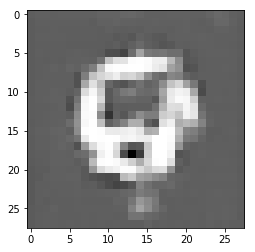

Iteration: 500
Discriminator Cost tensor(0.2119)
Generator Cost tensor(1.00000e-02 *
       6.9589)


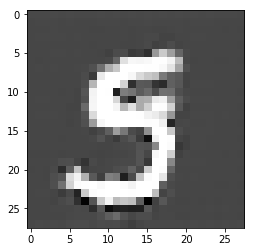

Iteration: 750
Discriminator Cost tensor(0.1900)
Generator Cost tensor(1.00000e-02 *
       8.4928)


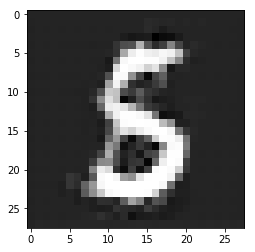

Iteration: 1000
Discriminator Cost tensor(0.1695)
Generator Cost tensor(1.00000e-02 *
       9.6663)


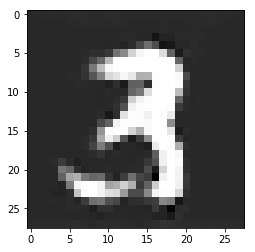

Iteration: 1250
Discriminator Cost tensor(0.1540)
Generator Cost tensor(0.1051)


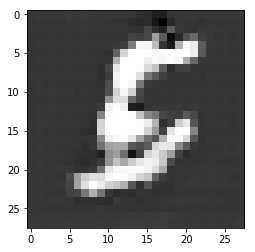

Iteration: 1500
Discriminator Cost tensor(0.1369)
Generator Cost tensor(0.1149)


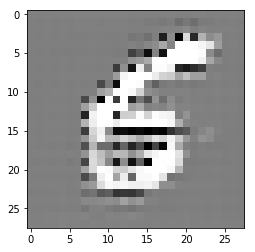

In [ ]:
train_gan(generator, discriminator, image_loader, epochs, num_train_batches=num_train_batches)